<h1 style='color:darkblue', align='center'>  Recommendation Engine using movies dataset </h1>

**In practice, recommendation engines are of three kinds:**

* [ popularity-based engines:]() Usually the most simple to implement be also the most impersonal. It keeps a track of view counts for each movie/video and then lists movies based on views in descending order if its for movie recommendation.
* [content-based engines:]() The recommendations are based on the description of the products. For example this type of recommendation systems, takes in a movie that a user currently likes as input. Then it analyzes the contents (storyline, genre, cast, director etc.) of the movie to find out other movies which have similar content.
* [collaborative filtering engines:]() Records from various users provide recommendations based on user similarities.


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df=pd.read_csv('movie_dataset.csv')

In [3]:
df.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [4]:
df.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

In [5]:
df.shape

(4803, 24)

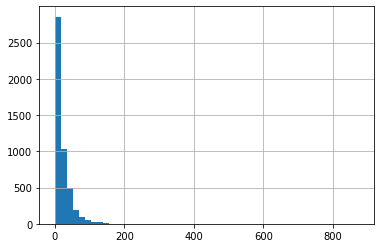

In [6]:
df.popularity.hist(bins=50)

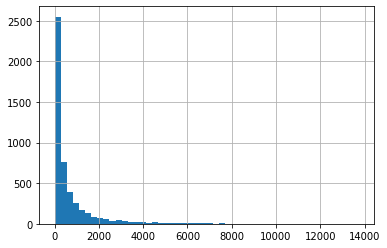

In [7]:
df.vote_count.hist(bins=50)

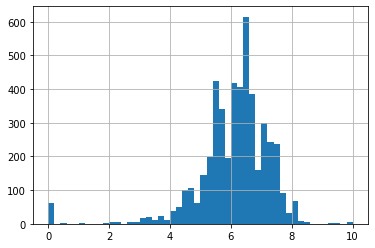

In [8]:
df.vote_average.hist(bins=50)

<h3 style="color:darkblue"> Popularity based recommendation or Demographic Filtering </h3> 

* The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. This is possible with just recommending in decending order of popularity column value, but to make it best recommendation we will Calculate the score for every movie
* Sort the scores and recommend the best rated movie to the users.
* We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, we'll be using IMDB's weighted rating (wr) which is given as :-
Weighted Rating = (v/(v+m)*R)+(m/(m+v)*C)

where,

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report
* We already have v(vote_count) and R (vote_average) and C can be calculated as


<h5> source: Ibtesam Ahmed Kaggle Notebook



In [9]:
#lets calculate C value
C= df['vote_average'].mean()
C

6.092171559442011

* From above its clear that ,the mean rating for all the movies is approx 6 on a scale of 10.
* Now, we will determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff.
* In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [10]:
m= df['vote_count'].quantile(0.9)
m

1838.4000000000015

In [11]:
# Lets filter movies based on our minimum vote criterion to get movies which qualify to be in recommendation list:
top_rec_list_movies = df.copy().loc[df['vote_count'] >= m]
top_rec_list_movies.shape

(481, 24)

In [12]:
# Now, will define the weighted rating 

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
top_rec_list_movies['score'] = top_rec_list_movies.apply(weighted_rating, axis=1)

In [14]:
#Sort movies based on score calculated above
top_rec_list_movies = top_rec_list_movies.sort_values('score', ascending=False)

#Print the top 20 movies
top_rec_list_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


<h4 style="color:maroon"> Finally we built [popularity based recommendation.]() This type of recommendation is given after selcting trending or popularity filtering on most platform like youtube etc by sorting the dataset by the popularity column.</h4>

Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- Content Basesd Filtering.

<h3 style="color:darkblue"> Content Based Recommendation:</h3>

After looking at dataset, we had seen that it has many extra info about a movie. We don’t need all of them. So, we choose keywords, cast, genres and director column to use as our feature set(the so called “content” of the movie).


In [15]:
features = ['keywords','cast','genres','director']

In [16]:
# now we will create a function for combining the values of these columns into a single string.

def all_feature_string(row):
    return row['keywords'] + " " + row['cast'] + " " + row['genres'] + " " + row['director']

In [17]:
df[features].isnull().any()

keywords    True
cast        True
genres      True
director    True
dtype: bool

In [18]:
#we will fill that all NaNs with blank string
for feature in features:
    df[feature] = df[feature].fillna('') 

In [19]:
#applying combined_features() method over each rows of dataframe and storing the combined string in "combined_features" column
df["all_feature_string"] = df.apply(all_feature_string,axis=1) 


In [20]:
df.iloc[2].all_feature_string


'spy based on novel secret agent sequel mi6 Daniel Craig Christoph Waltz L\\u00e9a Seydoux Ralph Fiennes Monica Bellucci Action Adventure Crime Sam Mendes'

In [21]:
#lets create word count matrix to find cosine similarity.
cv = CountVectorizer() #creating new CountVectorizer() object
word_count_matrix = cv.fit_transform(df["all_feature_string"]) #feeding combined strings(movie contents) to CountVectorizer() object

In [22]:
#lets find cosine similarity
similarity = cosine_similarity(word_count_matrix)
similarity[2]

array([0.12038585, 0.0761387 , 1.        , ..., 0.        , 0.11145564,
       0.        ])

In [23]:
# Reset index of our main DataFrame and construct reverse mapping
df = df.reset_index()
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [24]:
# Function that takes in movie title as input and outputs most similar movies
def recommendations(title, similarity=similarity):
       
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(similarity[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. we are excluding 0th title as its most similar movie
    #i.e. the same movie for which we are looking recommendations.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

def r2(title ,similarity):
    try:
        recommendations(title, similarity)
    except:
        print("Sorry, the movie is not in the database!")

**Just find the recommendations with our defined function**

In [25]:
r2('Avatar', similarity)

In [26]:
recommendations('Avatar', similarity)

94              Guardians of the Galaxy
2403                             Aliens
3208    Star Wars: Clone Wars: Volume 1
47              Star Trek Into Darkness
56                     Star Trek Beyond
3158                              Alien
2198                            Lockout
2696                            Jason X
4401                The Helix... Loaded
1531                          Moonraker
Name: title, dtype: object

<h4 style="color:maroon"> Finally we had built the content based recommendation on basis of content like ['keywords','cast','genres','director'] </h4>